In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 9]
%load_ext rpy2.ipython
import rpy2.robjects as robjects


In [2]:
df = pd.read_pickle('data/prop_data_gap_12_2_1_05_ct_NEST.pkl').drop_duplicates()

In [51]:
# --------- FILTERING ------------
reps_discarded = [20,41]
exp = 'DIA'

time_win = 12 #h
max_gap = 10 #s

df_filt = df.loc[(df.time_win==3600 * time_win) & 
                 (df.max_gap==max_gap) & 
                (df.exp.isin([exp+'a',exp+'b'])) & 
                (~df.rep.isin(reps_discarded))]
df_filt.insert(4,'h', [int(str(a)[-8:-6]) for a in df_filt.start])
df_filt = df_filt.sort_values(['rep','h'])

rep_to_colony = {i: i for i in range(57)} # TO DO generate dict REP to COLONY --------------------------
#rep_to_colony[55]=14

#df_filt.insert(5, 'colony', [rep_to_colony[j] for j in df_filt.rep])


# Export dataframe for stats
df_filt.to_csv('NTM_df_stats.csv')
df_filt
%R -i time_win

In [54]:
%%R -o prop_list -o pv_adj 

# -----------------------------
# Linear Mixed Effects Model (R)
# -----------------------------
rm(list=ls())
library(lme4)
library(car)

prop_list <- c('MOD','wDIA','wDEH','wDEN')
dat <- read.csv("NTM_df_stats.csv",header=T,stringsAsFactors = F)
  # list of properties for the LMER test
pv_list <- integer(0)

if (time_win == 12){rf = ' ~ exp +(1|rep)'}
    else{rf = ' ~ exp +(1|rep)+(1|h)'}

for (prop in prop_list){
  model <- lmer(formula(paste(prop,' ~ exp +(1|rep)')), data = dat)
  pv_list <- c(pv_list, print(as.numeric(Anova(model)["exp","Pr(>Chisq)"])))
}

pv_adj <- p.adjust(pv_list, method="BH")
names(pv_adj) <- prop_list

print(pv_adj)

RParsingError: Parsing status not OK - PARSING_STATUS.PARSE_ERROR

In [37]:
pv_dict = {prop_list[i]: pv_adj[i] for i in range(len(pv_adj))}

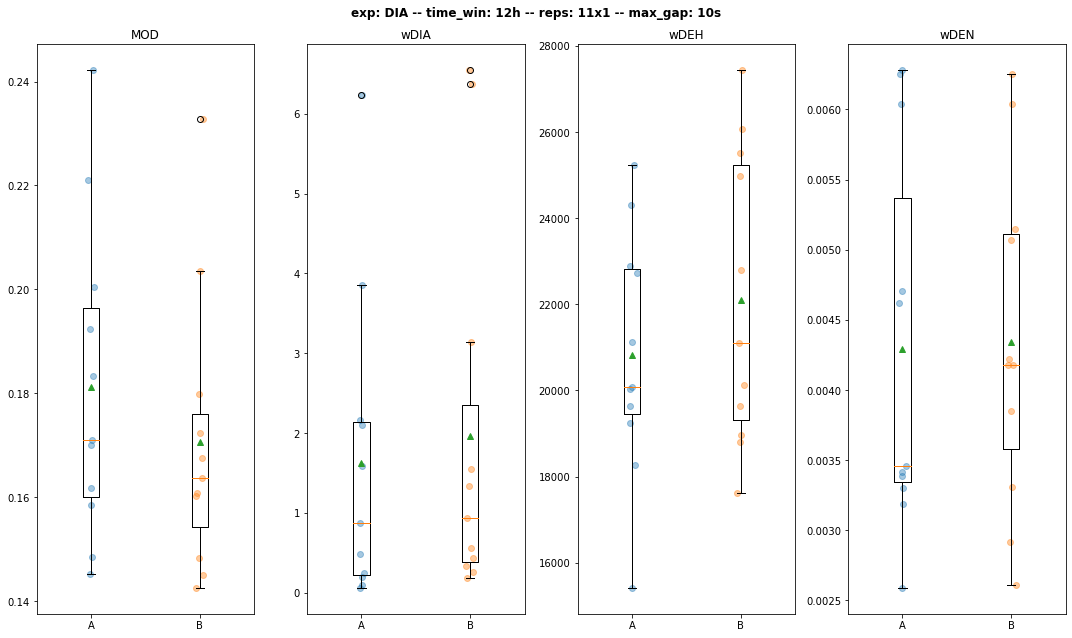

In [39]:
# Raw data specific property
fig, axs = plt.subplots(1, len(prop_list))

for idx_p, p in enumerate(prop_list):

    # dataframe for a-b comparison
    df_ab = pd.DataFrame()
    df_ab.insert(0, 'A', list(df_filt[p].iloc[::2]))
    df_ab.insert(1, 'B', list(df_filt[p].iloc[1::2]))
    df_ab


    # Plotting
    vals, names, xs = [],[],[]
    for i, col in enumerate(df_ab.columns):
        vals.append(df_ab[col].values)
        names.append(col)
        xs.append(np.random.normal(i + 1, 0.02, df_ab[col].values.shape[0]))  # adds jitter to the data points - can be adjusted


    box_plot = axs[idx_p].boxplot(vals, labels=names, showmeans=True)
    for x, val in zip(xs, vals):
        axs[idx_p].scatter(x, val, alpha=0.4)

    means = df_ab.mean()
    stds =  df_ab.std()
    
    axs[idx_p].set_title(p)
    
    # statistical annotation
    if pv_dict[p]<=0.05:
        stat_sign = '*' + (pv_dict[p]<=0.01)*'*' + (pv_dict[p]<=0.001)*'*' + (pv_dict[p]<=0.0001)*'*'
        x1, x2 = 1, 2   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        mm =np.max(df_ab.max())
        y, h, col = 1.05*mm, 0.01*mm, 'k'
        axs[idx_p].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
        axs[idx_p].text((x1+x2)*.5, y+h, stat_sign, ha='center', va='bottom', color=col, fontsize=20)

fig = plt.suptitle('exp: ' + exp + 
                    ' -- time_win: ' + str(time_win) + 'h'
                    ' -- reps: ' + str(int(len(df_ab)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                    ' -- max_gap: ' + str(max_gap) + 's',
                   fontweight="bold")
plt.tight_layout()
plt.show()

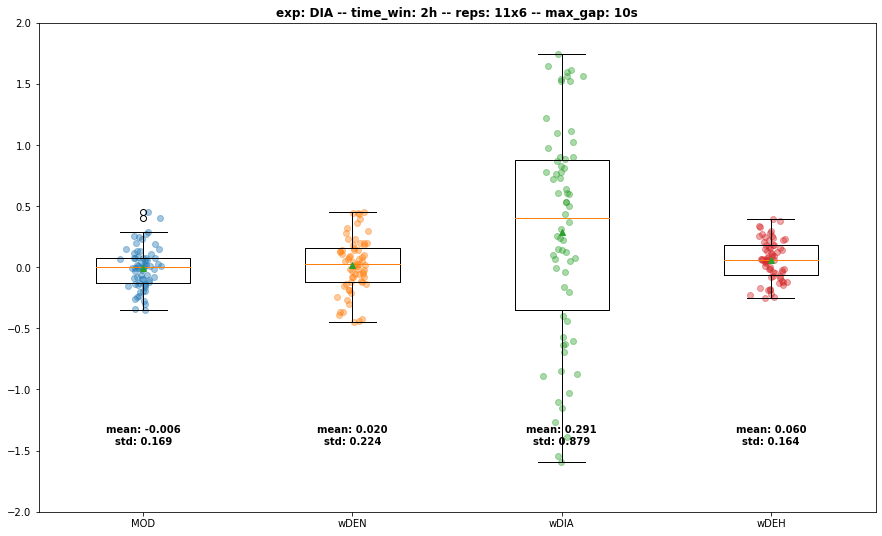

In [9]:
#===== RELATIVE DIFFERENCE =====


# ---- dataframe of relative difference---- 
p = ['MOD', 'wDEN', 'wDIA', 'wDEH']
df_rd = (df_filt[p].diff()/df_filt[p].rolling(2).mean()).iloc[1::2]
df_rd.insert(0,'rep', df_filt.rep.iloc[1::2])
df_rd.insert(1,'exp', [a[0:3] for a in df_filt.exp.iloc[1::2]])
df_rd.insert(3,'start-b', list(df_filt.start.iloc[1::2]))

vals, names, xs = [],[],[]
for i, col in enumerate(df_rd[p].columns):
    vals.append(df_rd[col].values)
    names.append(col)
    xs.append(np.random.normal(i + 1, 0.04, df_rd[col].values.shape[0]))  # adds jitter to the data points - can be adjusted

plt.figure()
box_plot = plt.boxplot(vals, labels=names, showmeans=True)
for x, val in zip(xs, vals):
    plt.scatter(x, val, alpha=0.4)

means = df_rd[p].mean()
stds =  df_rd[p].std()

for xtick in range(len(p)):
    plt.text(xtick+1,-1.35, 'mean: {:.3f}'.format(means[xtick]), 
              horizontalalignment='center',size='medium',color='k',weight='semibold')
    plt.text(xtick+1,-1.45, 'std: {:.3f}'.format(stds[xtick]), 
                  horizontalalignment='center',size='medium',color='k',weight='semibold')

plt.ylim([-2,2])
fig = plt.title('exp: ' + exp + 
                ' -- time_win: ' + str(time_win) + 'h'
                ' -- reps: ' + str(int(len(df_rd)*time_win/12)) + 'x' + str(int(12/time_win)) + 
                ' -- max_gap: ' + str(max_gap) + 's',
               fontweight="bold")